### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("data/web2/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("data/web2/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

C:\Users\konst\AppData\Local\Programs\Python\Python37\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [7]:
with open('data/web2/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

ipykernel_launcher:15: FutureWarning: Possible nested set at position 39
Wall time: 46.6 s


In [10]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 11min 8s


А теперь в 3 строчки обучим нашу модель

In [11]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [12]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [13]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 3min 12s


In [14]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [15]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(12, 0.39669445),
 (13, 0.05652284),
 (14, 0.1355633),
 (18, 0.09897874),
 (24, 0.29439574)]

In [16]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: ракета железный датчик польский пить курение рисунок
topic_1: год это который россия страна российский президент
topic_2: украина украинский киев проверка народный фронт гражданин
topic_3: район операция год экипаж пациент вода автомобиль
topic_4: предмет киргизия сертификат сражение двадцать детальный калинин
topic_5: белый дональд иск вицепремьер снять рт живой
topic_6: год млн рост компания тыс это цена
topic_7: медведев фильм мышь лекарство культура искусство японский
topic_8: ребёнок мужчина тело который это дело врач
topic_9: погибнуть обнаружить человек это произойти который результат
topic_10: белоруссия офицер белорусский виза минск армения японец
topic_11: человек взрыв который пострадать форум это произойти
topic_12: который это год мочь научный новый время
topic_13: статья год убийство лечение компания умереть следователь
topic_14: газ смерть фестиваль мероприятие nn болезнь пройти
topic_15: банк россия суд санкция гражданин рф власть
topic_16: земля станция сша nn

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [232]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

def get_idf(text):
    vectorizer = TfidfVectorizer(max_features=25)
    vectorizer.fit_transform(text)

    output_vector = []
    for i in range(25):
        if i < len(vectorizer.idf_):
            output_vector.append(vectorizer.idf_[i])
        else:
            output_vector.append(0)
    return output_vector


In [233]:
from sklearn.feature_extraction.text import TfidfVectorizer

# topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix = pd.DataFrame([get_idf(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,4.028522,4.721669,4.721669,5.127134,5.127134,4.210844,4.210844,4.433987,4.721669,...,5.127134,5.127134,5.127134,5.127134,4.433987,5.127134,5.127134,4.433987,4.433987,4.721669
1,4896,3.662588,3.662588,4.068053,4.068053,3.374906,4.068053,4.068053,4.068053,4.068053,...,4.068053,4.068053,4.068053,4.068053,4.068053,3.662588,4.068053,4.068053,4.068053,4.068053
2,4897,4.178054,4.178054,4.178054,3.772589,3.772589,4.178054,4.178054,4.178054,4.178054,...,4.178054,4.178054,4.178054,4.178054,4.178054,4.178054,4.178054,4.178054,3.484907,4.178054
3,4898,4.390024,4.390024,4.390024,4.390024,4.390024,4.390024,4.795489,4.795489,4.795489,...,4.795489,4.795489,4.795489,4.795489,4.795489,4.795489,4.795489,4.795489,4.795489,4.390024
4,4899,3.970414,3.970414,3.970414,3.970414,3.970414,3.564949,3.970414,3.970414,3.970414,...,3.970414,3.970414,3.970414,3.970414,3.970414,3.970414,3.277267,3.564949,3.970414,3.970414


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [19]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [235]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [236]:
doc_dict[293622]

array([4.91202301, 4.5065579 , 4.21887582, 4.5065579 , 4.5065579 ,
       4.5065579 , 4.5065579 , 4.5065579 , 4.91202301, 4.91202301,
       4.91202301, 4.91202301, 4.91202301, 4.5065579 , 4.91202301,
       4.5065579 , 4.91202301, 4.91202301, 4.91202301, 4.91202301,
       4.91202301, 4.91202301, 4.5065579 , 4.91202301, 4.5065579 ])

In [278]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # user_vector = np.mean(user_vector, 0)
    # user_vector = np.median(user_vector, 0)
    user_vector = np.max(user_vector, 0)
    return user_vector

In [279]:
get_user_embedding(user_articles_list)

array([5.30406509, 5.90190209, 5.81489072, 5.99721227, 5.59174717,
       5.73484801, 5.99721227, 5.04305127, 5.99721227, 5.99721227,
       5.20875491, 5.99721227, 5.40942561, 5.81489072, 5.40942561,
       5.90190209, 5.73484801, 5.99721227, 5.25527493, 5.59174717,
       5.90190209, 5.99721227, 4.88499433, 5.81489072, 5.66074004])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [280]:
#users['articles'].iloc[33]

In [281]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [282]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,5.418841,5.641984,5.418841,5.418841,5.236519,5.641984,5.641984,5.418841,5.418841,...,5.236519,5.418841,5.418841,5.641984,5.236519,5.641984,5.236519,5.418841,5.641984,5.236519
1,u108690,5.620059,5.620059,5.343805,5.749271,5.749271,5.597138,5.620059,5.709530,5.620059,...,5.749271,5.749271,5.749271,5.597138,5.709530,5.709530,5.620059,5.622519,5.622519,5.622519
2,u108339,5.607168,5.861749,5.824306,5.638605,5.572991,5.755313,5.638605,5.978456,5.607168,...,5.755313,5.978456,5.755313,5.830312,5.861749,5.755313,5.601162,5.861749,5.861749,5.601162


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [283]:
target = pd.read_csv("data/web2/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [284]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,5.418841,5.641984,5.418841,5.418841,5.236519,5.641984,5.641984,5.418841,5.418841,...,5.418841,5.418841,5.641984,5.236519,5.641984,5.236519,5.418841,5.641984,5.236519,0
1,u108690,5.620059,5.620059,5.343805,5.749271,5.749271,5.597138,5.620059,5.709530,5.620059,...,5.749271,5.749271,5.597138,5.709530,5.709530,5.620059,5.622519,5.622519,5.622519,1
2,u108339,5.607168,5.861749,5.824306,5.638605,5.572991,5.755313,5.638605,5.978456,5.607168,...,5.978456,5.755313,5.830312,5.861749,5.755313,5.601162,5.861749,5.861749,5.601162,1


In [285]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [286]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [287]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [288]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([2.43421698e-01, 5.24368753e-03, 7.05984971e-01, 5.76617271e-03,
       4.35806037e-06, 5.60653009e-02, 8.22539850e-04, 1.51235696e-03,
       2.90846993e-03, 6.79117196e-05])

In [289]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [290]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.213774, F-Score=0.793, Precision=0.678, Recall=0.955


In [291]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1644  111]
 [  12  233]]


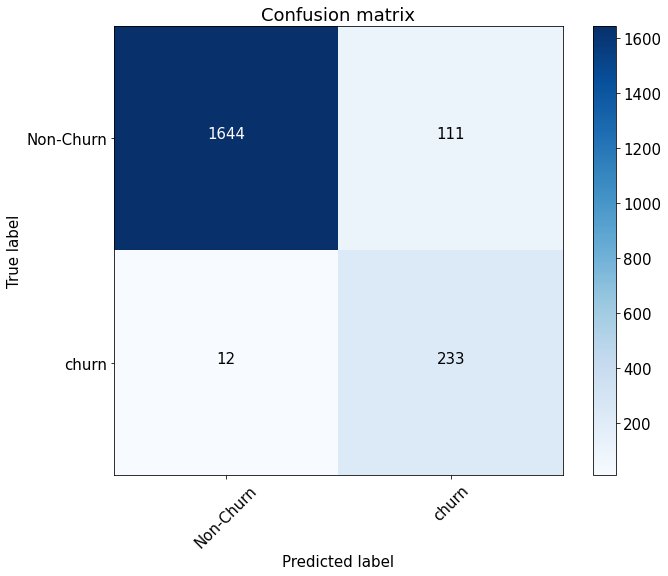

In [292]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [293]:
roc_auc_score(y_test, preds)

0.9742217570789

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

## Домашнее задание

### Задание #4
    def get_idf(text):

        vectorizer = TfidfVectorizer(max_features=25)
        vectorizer.fit_transform(text)

        output_vector = []
        for i in range(25):
            if i < len(vectorizer.idf_):
                output_vector.append(vectorizer.idf_[i])
            else:
                output_vector.append(0)
        return output_vector

### Задание #5

In [296]:
result = pd.DataFrame(
    data={
        'F-Score': [0.683, 0.809, 0.768, 0.998],
        'Precision': [0.648, 0.832, 0.753, 0.996],
        'Recall': [0.722, 0.788, 0.784, 1.0],
        'ROC AUC': [0.949, 0.978, 0.970, 0.999]
    },
    index=['mean', 'median', 'max', 'idf_mean'],
)
result

,F-Score,Precision,Recall,ROC AUC
mean,0.683,0.648,0.722,0.949
median,0.809,0.832,0.788,0.978
max,0.768,0.753,0.784,0.970
idf_mean,0.998,0.996,1.000,0.999


### Задание #6

Выбор среднего медианой устойчив к выбросам. Отсюда он выглядит лучше по сравнению с mean и max.

Получение весов через idf показывает лучшие результаты, тк этот метод позволяет выявить наиболее информативные фичи.